In [1]:
#imports
from __future__ import division
import time
import datetime
import copy
from itertools import product
import operator
from collections import OrderedDict

import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier,\
    GradientBoostingRegressor,\
    RandomForestRegressor,\
    GradientBoostingClassifier
from sklearn.metrics import accuracy_score, r2_score

import altair as alt
alt.renderers.enable("notebook")
import ipywidgets as wid
from IPython.display import display

In [551]:
class ForestForTheTrees:
    
    DEFAULT_SAMPLE_SIZE = 500
    DEFAULT_LEARNING_RATE = 1.
    
    def __init__(self):
        
        self.dataset = None
        self.x = None
        self.y = None
        self.feature_names = None
        self.feature_locs = None
        self.feature_ranges = {}
        self.target_type = None
        self.classifier_type = None
        self.classifier = None
        self.mean_prediction = None
        self.no_predictor_features = []
        self.oned_features = []   
        self.binned_data = None
        self.sample_size = self.DEFAULT_SAMPLE_SIZE
        self.num_tiles = None
        self.quantiles = None
        self.learning_rate = self.DEFAULT_LEARNING_RATE
        self.predictions_base = None
        self.chart_components = {}
        self.explanation_components = {}
        self.base_explanation = []
        self.evaluation_details = []
        self.base_components = []
        self.explanation = []
        self.cache = {}
        
    def __init__(self, dataset, sample_size, num_tiles, quantiles, learning_rate):
        
        self.classifier_type = None
        self.classifier = None
        self.mean_prediction = None
        self.no_predictor_features = []
        self.oned_features = []   
        self.binned_data = None
        self.sample_size = sample_size 
        self.num_tiles = num_tiles
        self.quantiles = quantiles
        self.learning_rate = learning_rate
        self.predictions_base = None
        self.chart_components = {}
        self.explanation_components = {}
        self.base_explanation = []
        self.evaluation_details = []
        self.base_components = []
        self.explanation = []
        self.cache = {}
        self.load_dataset(dataset)
        
    def set_sample_size(self, new_size):
        self.sample_size = new_size
    
    def get_dataset(self, dataset):
        
        if dataset == "breast cancer":
            dataLoad = datasets.load_breast_cancer(return_X_y=False)
            return {
                "x": dataBunch.data[:,:10],
                "y": dataBunch.target,
                "feature_names": dataBunch.feature_names[:10],
                "feature_locs": {x:i for i,x in enumerate(dataBunch.feature_names[:10])},
                "target_type": "classification"
            }     
        elif dataset == "cervical cancer":
            dataLoad = pd.read_csv("data/cervical_cancer.csv")
            target = dataLoad.Biopsy
            dataLoad = dataLoad.drop(["Person", "Biopsy"],axis=1)
            return {
                "x": dataLoad.values,
                "y": target,
                "feature_names": dataLoad.columns,
                "feature_locs": {x:i for i,x in enumerate(dataLoad.columns)},
                "target_type": "classification"
            }
        elif dataset == "bike":
            def _datestr_to_timestamp(s):
                return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d").timetuple())

            dataLoad = pd.read_csv('data/bike.csv')
            dataLoad['dteday'] = dataLoad['dteday'].apply(_datestr_to_timestamp)
            dataLoad = pd.get_dummies(dataLoad, prefix=["weathersit"], columns=["weathersit"], drop_first = False)

            #de-normalize data to produce human-readable features.
            #Original range info from http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
            dataLoad["hum"] = dataLoad["hum"].apply(lambda x: x*100.)
            dataLoad["windspeed"] = dataLoad["windspeed"].apply(lambda x: x*67.)
            #convert Celsius to Fahrenheit
            dataLoad["temp"] = dataLoad["temp"].apply(lambda x: (x*47. - 8)*9/5 +32)
            dataLoad["atemp"] = dataLoad["atemp"].apply(lambda x: (x*66. - 16)*9/5 + 32)

            #rename features to make them interpretable for novice users
            feature_names_dict = {
                "yr":"First or Second Year", 
                "season":"Season", 
                "hr":"Hour of Day", 
                "workingday":"Work Day",
                "weathersit_2":"Misty Weather",
                "weathersit_3":"Light Precipitation",
                "weathersit_4":"Heavy Precipitation",
                "temp":"Temperature (F)",
                "atemp":"Feels Like (F)",
                "hum":"Humidity",
                "windspeed":"Wind Speed"
            }
            dataLoad = dataLoad.rename(mapper=feature_names_dict,axis=1) 
            features = feature_names_dict.values()

            return {
                "x": dataLoad[features].values,
                "y": dataLoad["cnt"],
                "feature_names": features,
                "feature_locs": {x:i for i,x in enumerate(features)},
                "target_type": "regression"
            }

    def bin_data(self):
    
        prediction_contributions = {}
        sample_data = pd.DataFrame(
            self.get_sample(self.x),
            columns = self.feature_names
        )
        for key in self.get_feature_pairs():
            tempH = np.digitize(
                sample_data.loc[:,key[0]],
                self.feature_ranges[key[0]]
            )-1.
            tempV = np.digitize(
                sample_data.loc[:,key[1]],
                self.feature_ranges[key[1]]
            )-1.
            prediction_contributions[key] = (tempV*len(self.feature_ranges[key[0]]) + tempH).astype(int)
        return prediction_contributions        
        
    def load_dataset(self, dataset):

        self.dataset = dataset
        data = self.get_dataset(self.dataset)
        self.x = data["x"]
        self.y = data["y"]
        self.feature_names = data["feature_names"]
        self.feature_locs = data["feature_locs"]
        self.target_type = data["target_type"]
        self.feature_ranges = {
            feature : self.get_quantiles(feature)
            for feature in self.feature_names
        }  
        self.binned_data = self.bin_data()    
            
    def build_base_model(self, num_estimators, model_type):

        model_lookup_dict = {
            ("classification", "random forest") : RandomForestClassifier,
            ("classification", "gradient boosting") : GradientBoostingClassifier,
            ("regression", "random forest") : RandomForestRegressor,
            ("regression", "gradient boosting") : GradientBoostingRegressor
        }

        self.model_type = model_type
        self.classifier_type = model_lookup_dict[(self.target_type, self.model_type)]

        self.model = self.classifier_type(n_estimators=num_estimators, max_depth=2, learning_rate = self.learning_rate)
        self.model.fit(self.x, self.y)
        self.pred_y = self.model.predict(self.x)

    def get_model_accuracy(self):
        if self.target_type == "classification":
            return accuracy_score(self.y, self.pred_y)
        else:
            return r2_score(self.y, self.pred_y)    
        
    def _get_coordinate_matrix(self, lst, length, direction):
        if direction=="h":
            return lst*length
        else:
            return [item for item in lst\
             for i in range(length)]   

    def get_quantile_matrix(self, feat1, feat2):
        h = self._get_coordinate_matrix(
            list(self.feature_ranges[feat1]),
            len(self.feature_ranges[feat2]),
            "h"
        )
        v = self._get_coordinate_matrix(
            list(self.feature_ranges[feat2]),
            len(self.feature_ranges[feat1]),
            "v"
        )                      
        return h,v 

    def get_leaf_value(self, tree, node_position):
        node = tree.value[node_position]
        if self.target_type == "classification":
            return node[0][1]/(node[0][1] + node[0][0])
        else:
            return node        

    def get_feature_pair_key(self, feat1, feat2):
        if self.feature_ranges[feat1].shape[0] == self.feature_ranges[feat2].shape[0]:
            #need stable order so keys with same number of quantiles appear in only one order
            return tuple(sorted([feat1, feat2]))
        elif self.feature_ranges[feat1].shape[0] > self.feature_ranges[feat2].shape[0]:
            return tuple([feat1, feat2])
        else:
            return tuple([feat2, feat1])        

    def get_quantiles(self, feat):
        loc = self.feature_locs[feat]
        if np.unique(self.x[:,loc]).shape[0] < 30 or type(self.x[0,loc]) is str: #is categorical/ordinal?
            return np.unique(self.x[:,loc])
        else:
            if self.quantiles:
                return np.around(
                    np.unique(
                        np.quantile(
                            a=self.x[:,loc],
                            q=np.linspace(0, 1, self.num_tiles)
                        )
                    ),
                    1)
            else:
                return np.around(
                    np.linspace(
                        np.min(self.x[:,loc]), 
                        np.max(self.x[:,loc]),
                        self.num_tiles
                    )
                    ,1)  
            
    def reduce_to_1d(self, arr, threshold, direction):
        if direction == "h":
            reduced_arr = arr - arr[:,0].reshape(-1,1)
        else:
            reduced_arr = arr - arr[0,:].reshape(1,-1)
        return (np.max(np.abs(reduced_arr))/np.max(np.abs(arr))) <= threshold               
        
    def get_sample(self, arr):
        return arr[:self.sample_size]
    
    def get_predictions_base(self):
        return np.full((self.sample_size,1), np.mean(self.y))
    
    def get_empty_sample(self, size = None):
        return np.full((self.sample_size if size is None else size,1), 0)
    
    def get_explanation_accuracy(self, explanation_predictions):
        if self.target_type == "regression":
            return r2_score(self.get_sample(self.pred_y), explanation_predictions)
        
    def get_prediction_contributions(self, chart, data_positions):
        return np.take(chart, data_positions)
    
    def sum_arrays(self, temp_outputs, keyMain, keyAdd, arr_to_add):
        return temp_outputs[keyMain]["output"]\
    + temp_outputs[keyAdd][arr_to_add].reshape(
            temp_outputs[keyMain]["output"].shape[0]
            if(keyMain[1]==keyAdd[1] or keyMain[1]==keyAdd[0])
            else 1,-1
        )
    
    def _drop_alternate_outputs(self,component):
        return {"output": component["output"]}
    
    def _get_prediction_contributions_df(self, components, explanation):
        return np.hstack(
            tuple(
                [
                    self.get_prediction_contributions(
                        components[expKey]["output"],
                        self.binned_data[expKey]
                    ).reshape(-1, 1)\
                    for expKey in explanation                    
                ]
            )
        )
    
    def _get_prediction_contributions_by_key(self, components, explanation):
        return {
            expKey : 
            self.get_prediction_contributions(
                components[expKey]["output"],
                self.binned_data[expKey]
            ) for expKey in explanation
        }        

    def evaluate_single_explanation(self, components, explanation):
        
        return self.get_explanation_accuracy(
            self.predictions_base +\
            np.sum(
                np.array(
                    self._get_prediction_contributions_by_key(
                        components,
                        explanation
                    ).values()
                ), 
                axis = 0
            ).reshape(-1,1)
        )
    
    def _get_parallel_coordinate_columns(self, explanation, cumulative):
        #make these strings because Altair doesn't like a tuple as a key and turns it into a list
        return (["mean y"] if cumulative else [])\
    + [x[0] + "," + x[1] for x in explanation]\
    + (["prediction"] if cumulative else [])
    
    def _get_altair_data_type(self,feature_name, abbreviation = True):
        if self.feature_ranges[feature_name].shape[0] == self.num_tiles:
            return "Q" if abbreviation else "quantitative"
        else:
            return "O" if abbreviation else "ordinal"    
    
    def _get_datapoint_contributions(self, components, explanation):
        contributions = self._get_prediction_contributions_df(components, explanation)
        #raw contributions
        arr = np.hstack(
            (
                self.get_empty_sample().reshape(-1,1),
                contributions.reshape(self.sample_size, -1),
                self.get_sample(self.pred_y).reshape(-1,1),
                np.array([0. for x in range(self.sample_size)]).reshape(-1,1)
            )
        )
        
        #cumulative version
        arr_cum = np.cumsum(
            np.hstack(
                (
                    self.get_predictions_base().reshape(-1,1),
                    contributions.reshape(self.sample_size,-1)
                )
            ),
            axis = 1
        )
        
        arr_cum = np.hstack(
            (
                arr_cum,
                self.get_sample(self.pred_y).reshape(-1,1),
                np.array([1. for x in range(self.sample_size)]).reshape(-1,1)
            )
        )

        arr_df = pd.DataFrame(
            arr,
            columns = self._get_parallel_coordinate_columns(explanation, True) + ["view"]
        )
        
        #combine arrays
        arr_cum_df = pd.DataFrame(
            arr_cum,
            columns = self._get_parallel_coordinate_columns(explanation, True) + ["view"]
        )
        
        #generate datapoint id columns
        arr_df = arr_df.reset_index(drop = False)
        arr_cum_df = arr_cum_df.reset_index(drop = False)
        datapoints = pd.concat([arr_df, arr_cum_df])
        
        #couldn't do this earlier, as you can't vstack a mixed type array
        datapoints["view"] = datapoints["view"].apply(lambda x:\
                                                      'Predictions by Chart'\
                                                      if x < 1. else\
                                                      'Cumulative Predictions'\
                                                     )
        #calculate explanation loss
        datapoints["explanation_loss"] = np.abs( #otherwise the chart is hard to read with 0 in the middle of the axis
            datapoints.loc[:,"prediction"] - datapoints.iloc[:,-3]#last cumulative column
        )
        
        #datapoints = datapoints.reset_index(drop = False)
        datapoints["prediction_index"] = datapoints["prediction"]
        datapoints = datapoints.melt(
            id_vars = ['index', "prediction_index", "view", "explanation_loss"],
            var_name = 'component',
            value_name = 'contribution'
        )
        
        #rename prediction again
        datapoints = datapoints.rename({"prediction_index" : "prediction"}, axis = 1)

        #drop fake columns for "Predictions by Chart"
        datapoints = datapoints[
            (datapoints["view"] == "Cumulative Predictions")
            | (~datapoints["component"].isin(["prediction", "mean y", "explanation_loss"]))
        ]
        
        #build sort column for Altair
        datapoints["sort"] = datapoints["component"].apply(lambda x:
                                                           self._get_parallel_coordinate_columns(
                                                               explanation,
                                                               True
                                                           ).index(x)
                                                          )   
        return datapoints

    def copy_chart_components(self):
        return copy.deepcopy(self.chart_components)  
    
    def get_feature_pairs(self):
        return [
            self.get_feature_pair_key(key[0], key[1])
            for key in [tuple(t) for t in product(self.feature_names, repeat = 2)]
        ]       

    def rollup_components(self, explanation):
        temp_outputs = self.copy_chart_components()
        for keyRollup in [k for k in self.chart_components.iterkeys() if k not in explanation]:
            hUsed = False
            vUsed = False
            for keyExisting in explanation:
                if (keyRollup[1] == keyExisting[0] or keyRollup[1] == keyExisting[1]) and not hUsed:
                    hUsed = True
                    if vUsed:
                        temp_outputs[keyExisting]["output"] = self.sum_arrays(
                            temp_outputs,
                            keyExisting, 
                            keyRollup,
                            "output_HReduced"
                        )
                        break
                    else:
                        temp_outputs[keyExisting]["output"] = self.sum_arrays(
                            temp_outputs,
                            keyExisting, 
                            keyRollup,
                            "output_H"
                        )                           
                elif (keyRollup[0] == keyExisting[0] or keyRollup[0] == keyExisting[1]) and not vUsed:
                    vUsed = True
                    if hUsed:
                        temp_outputs[keyExisting]["output"] = self.sum_arrays(
                            temp_outputs,
                            keyExisting, 
                            keyRollup,
                            "output_VReduced"
                        )                          
                        break
                    else:
                        temp_outputs[keyExisting]["output"] = self.sum_arrays(
                            temp_outputs,
                            keyExisting, 
                            keyRollup,
                            "output_V"
                        )  
        return temp_outputs    
    
    def extract_components(self, collapse_1d = True):

        #generate data structure for pairwise charts
        feature_pairs = {
            key : {
                "map":None,
                "predicates":[]
            }
            for key in self.get_feature_pairs()
        }      

        for key, value in feature_pairs.iteritems():
            h, v = self.get_quantile_matrix(key[0], key[1])
            value["map"] = np.array(
                [
                    {
                        key[0] : x,
                        key[1] : y
                    }
                    for x,y in zip(h,v)
                ]
            ).reshape(len(self.feature_ranges[key[1]]), len(self.feature_ranges[key[0]]))

        for modelT in self.model.estimators_:
            if self.target_type == "regression":
                curr_model = modelT[0]
            else:
                curr_model = modelT
            feature_ids = {i : 
                           {
                               "number":x,
                               "name":self.feature_names[x]
                           } for i,x in enumerate(list(curr_model.tree_.feature)) if x >= 0} #-2 means leaf node

            #for 1-layer trees
            if curr_model.tree_.feature[1] < 0:
                feature_pair_key = self.get_feature_pair_key(
                    feature_ids[0]["name"],
                    feature_ids[0]["name"]
                )
                decision_func_dict = {
                    "feature_name": feature_ids[0]["name"],
                    "threshold": curr_model.tree_.threshold[0],
                    "operator": operator.le,
                    "prob_le": self.get_leaf_value(curr_model.tree_, 1),
                    "prob_gt": self.get_leaf_value(curr_model.tree_, 2)
                }       
                #build the predictive function used in the decision tree
                def dt_predicate(data_case, decision_func_dict=decision_func_dict):
                    if decision_func_dict["operator"](\
                                                        data_case[decision_func_dict["feature_name"]],\
                                                        decision_func_dict["threshold"]\
                                                       ):
                        return decision_func_dict["prob_le"]
                    else:
                        return decision_func_dict["prob_gt"]        
            else:
                for node_position in [1,4]: #positions for left and right nodes at layer 2
                    if node_position in feature_ids:
                        feature_pair_key = self.get_feature_pair_key(
                            feature_ids[0]["name"], 
                            feature_ids[node_position]["name"]
                        )
                        #get the decision rules
                        decision_func_dict = {
                            "feature_name_1": feature_ids[0]["name"],
                            "threshold_1": curr_model.tree_.threshold[0],
                            "operator_1": operator.le if node_position == 1 else operator.gt,

                            "feature_name_2": feature_ids[node_position]["name"],
                            "threshold_2": curr_model.tree_.threshold[node_position],
                            "operator_2": operator.le,

                            "prob_le": self.get_leaf_value(curr_model.tree_, node_position+1),
                            "prob_gt": self.get_leaf_value(curr_model.tree_, node_position+2)
                        }
                        #build the predictive function used in the decision tree
                        def dt_predicate(data_case, decision_func_dict=decision_func_dict):
                            if decision_func_dict["operator_1"](\
                                                                data_case[decision_func_dict["feature_name_1"]],\
                                                                decision_func_dict["threshold_1"]\
                                                               ):
                                if decision_func_dict["operator_2"](\
                                                                    data_case[decision_func_dict["feature_name_2"]],\
                                                                    decision_func_dict["threshold_2"]\
                                                                   ):
                                    return decision_func_dict["prob_le"]
                                else:
                                    return decision_func_dict["prob_gt"]
                            else:
                                return 0.

                    else: #asymmetric tree, this is a leaf node
                        feature_pair_key = self.get_feature_pair_key(
                            feature_ids[0]["name"], 
                            feature_ids[0]["name"]
                        )
                        decision_func_dict = {
                            "feature_name": feature_ids[0]["name"],
                            "threshold": curr_model.tree_.threshold[0],
                            "operator": operator.le if node_position == 1 else operator.gt,
                            "prob": curr_model.tree_.value[node_position]
                        }
                        #build the predictive function used in the decision tree
                        def dt_predicate(data_case, decision_func_dict=decision_func_dict):
                            if decision_func_dict["operator"](\
                                                                data_case[decision_func_dict["feature_name"]],\
                                                                decision_func_dict["threshold"]\
                                                               ):
                                return decision_func_dict["prob"]
                            else:                         
                                return 0.                 

                    feature_pairs[feature_pair_key]["predicates"].append(dt_predicate)

        #now calculate output array for each feature pair
        for key, value in feature_pairs.iteritems():
            arrs = []
            for predicate in value["predicates"]:
                f = np.vectorize(predicate)
                arrs.append(f(value["map"]))
            if len(arrs) > 0:
                #details of vote aggreggation method for random forest
                #https://stats.stackexchange.com/questions/127077/random-forest-probabilistic-prediction-vs-majority-vote
                value["output"] = np.sum(np.stack(arrs, axis=-1), axis=-1)*self.learning_rate 
            else:
                value["output"] = None

        #build chart data
        for key, value in feature_pairs.iteritems():
            h,v = self.get_quantile_matrix(key[0], key[1])
            value["h_indices"] = h
            value["v_indices"] = v    

        self.no_predictor_features = []
        self.oned_features = []
        chart_data = {}
        for key, value in feature_pairs.iteritems(): 
            newKey = key
            if value["output"] is None:
                self.no_predictor_features.append(key)
                value["removed"] = True
            else:          
                if collapse_1d:
                    if self.reduce_to_1d(value["output"], 0., "v"):
                        newKey = key[1]
                        value["output"] = value["output"][0,:]
                        value["h_indices"] = self.feature_ranges[newKey]
                        value["v_indices"] = None
                        value["1d_key"] = newKey
                        value["removed"] = True
                        self.oned_features.append(key)                 
                    elif self.reduce_to_1d(value["output"], 0., "h"):
                        newKey = key[0]
                        value["output"] = value["output"][:,0]
                        value["h_indices"] = self.feature_ranges[newKey]
                        value["v_indices"] = None
                        value["1d_key"] = newKey
                        value["removed"] = True
                        self.oned_features.append(key)

        #do another loop through chart_data to push 1d charts into 2d
        if collapse_1d:
            for value in feature_pairs.itervalues():
                if value["v_indices"] is None:
                    key = value["1d_key"]
                    #get list of charts with this feature
                    matchList = sorted([{"key": kInner, "feature_importance": np.std(vInner["output"])}\
                                        for kInner, vInner in feature_pairs.iteritems()\
                                        if "removed" not in vInner and key in kInner],\
                                       key=lambda x: x["feature_importance"], reverse=True)

                    if len(matchList) > 0:
                        matchKey = matchList[0]["key"]
                        feature_pairs[matchKey]["output"] = feature_pairs[matchKey]["output"]\
                        + value["output"].reshape(\
                                                  -1 if key == matchKey[1] else 1,\
                                                  -1 if key == matchKey[0] else 1\
                                                 )

        #one last loop to generate the horizontal and vertical components
        for key, value in feature_pairs.iteritems():
            if "removed" in value:
                pass
            else:
                value["output_H"] = np.mean(value["output"], axis=1).reshape(-1,1)
                value["output_V"] = np.mean(value["output"], axis=0).reshape(1,-1)
                value["output_HReduced"] = np.mean(value["output"] - value["output_V"].reshape(1,-1), axis=1)\
                .reshape(1,-1)
                value["output_VReduced"] = np.mean(value["output"] - value["output_H"].reshape(-1,1), axis=0)\
                .reshape(-1,1)

        #remove deleted keys
        feature_pairs = {key:val for key, val in feature_pairs.iteritems() if "removed" not in val}
        feature_pairs = OrderedDict(sorted(feature_pairs.items(),\
                                            key=lambda x: np.std(x[1]["output"]), reverse=True))
        self.chart_components = {key: {
            "output" : val["output"],
            "output_VReduced" : val["output_VReduced"],
            "output_H" : val["output_H"],
            "output_HReduced" : val["output_HReduced"],
            "output_V" : val["output_V"]
        } for key, val in feature_pairs.iteritems()}

        self.chart_indices = {key: {
            "h_indices" : val["h_indices"],
            "v_indices" : val["v_indices"]
        } for key, val in feature_pairs.iteritems()}  
        
        self.predictions_base = self.get_predictions_base()
        
        #get the full explanation and store it. one reason for this is so that charts can also be sorted appropriately
        #don't save explanation components as they will be the same as chart_components
        self.base_explanation, _, _\
        = self._explain(1., None)
        
    def _explain(self, fidelity_threshold = 1., rollup = None):

        explanation = []   
        explanation_components = {}
        evaluation_details = [
            {
                "score": self.get_explanation_accuracy(
                    self.predictions_base
                )
            }
        ]
        
        while evaluation_details[-1]["score"] < fidelity_threshold\
        and len(explanation) < len(self.chart_components):
            current_details = {}
            temp_outputs = {}
            keys_to_evaluate = [key for key in self.chart_components.iterkeys() if key not in explanation]
            for key in keys_to_evaluate:
                #roll up other keys
                current_explanation = explanation+[key]
                temp_outputs[key] = self.rollup_components(current_explanation)\
                if rollup == "advanced"\
                else self.copy_chart_components()

                current_details[key] = self.evaluate_single_explanation(temp_outputs[key], current_explanation)

            #get key with highest fidelity score
            best_key = max(
                current_details.iterkeys(),\
                key = (lambda key: current_details[key])
            )
            explanation.append(best_key)
            current_details["best_key"] = best_key

            if rollup == "simple":
                temp_outputs[best_key] = self.rollup_components(explanation)
                current_details[best_key] = self.evaluate_single_explanation(temp_outputs[best_key], explanation)

            
            current_details["score"] = current_details[best_key]
            evaluation_details.append(current_details)
            explanation_components = {k : self._drop_alternate_outputs(v)\
                                      for k, v in temp_outputs[best_key].iteritems()}
        return explanation, explanation_components, evaluation_details
    
    def explain(self, fidelity_threshold = 1., rollup = None):
        self.explanation, self.explanation_components, self.evaluation_details\
        = self._explain(fidelity_threshold, rollup)
        
    def cache_visualize_components(self, start = 1, end = 100, step = 1):
        self.cache["play_components"] = []
        for i in range(start, end+1, step):
            f3t = ForestForTheTrees(
                dataset = self.dataset,
                sample_size = self.sample_size,
                num_tiles = self.num_tiles,
                quantiles = self.quantiles,
                learning_rate = self.learning_rate
            )
            f3t.build_base_model(i, self.model_type)
            f3t.extract_components(True)
            self.cache["play_components"].append(
                {
                    "explanation" : f3t.base_explanation,
                    "components" : f3t.chart_components,
                    "chart_indices" : f3t.chart_indices
                }
            )
        
    def cache_visualize_datapoints(self):
        
        minimal = self._get_datapoint_contributions(
            self.explanation_components,
            self.explanation
        )
        
        full = self._get_datapoint_contributions(
            self.explanation_components,
            self.base_explanation
        )
        
        minimal["explanation"] = "minimal"
        full["explanation"] = "full"
        
        self.cache["datapoints"] = pd.concat([minimal, full])
        
    def visualize_datapoints(self, cumulative = False, num_datapoints = 50, explanation_type = "minimal",
                            color_encoding = "prediction"):
        output = self._visualize_datapoints(explanation_type, cumulative, num_datapoints, color_encoding)
        display(output)
        return output
    
    def _visualize_datapoints(self, explanation_type, cumulative, num_datapoints, color_encoding):
        
        explanation_to_visualize = self.explanation\
        if len(self.explanation) > 0 and explanation_type == "minimal"\
        else self.base_explanation        
        
        if "datapoints" in self.cache and self.cache["datapoints"] is not None:
            datapoints = self.cache["datapoints"]
            datapoints = datapoints[datapoints["explanation"] == explanation_type]
        
        else:            
            datapoints = self._get_datapoint_contributions(
                self.explanation_components,
                explanation_to_visualize
            )
        
        unique_datapoint_ids = np.unique(datapoints.loc[:,"index"])
        sample_datapoint_ids = np.random.choice(unique_datapoint_ids, num_datapoints, replace = False)
        datapoints = datapoints[datapoints["index"].isin(sample_datapoint_ids)]
        datapoints = datapoints[datapoints["view"] == ("Cumulative Predictions"\
                                                       if cumulative\
                                                       else "Predictions by Chart")
                               ]
        
        df_raw = pd.DataFrame(self.x, columns = self.feature_names)
        df_raw["prediction"] = self.pred_y
        df_raw = df_raw.reset_index(drop = False)
        df_raw = df_raw[df_raw["index"].isin(sample_datapoint_ids)]       
        
        brush = alt.selection_multi()
        chart = alt.Chart(data = datapoints)\
        .mark_line()\
        .encode(
            x = alt.X(
                field = 'component',
                type = 'nominal',
                axis = alt.Axis(labelAngle = -30),
                sort = self._get_parallel_coordinate_columns(explanation_to_visualize, cumulative)
            ),
            y ='contribution:Q',
            color = alt.condition(
                brush,
                alt.Color(
                    field = color_encoding,
                    type = "quantitative",
                    scale = alt.Scale(scheme = "plasma")
                ),
                alt.value("lightgray")
            ),
            opacity = alt.condition(
                brush,
                alt.value(1.0),
                alt.value(0.2)
            ),
            tooltip = [
                alt.Tooltip(x+":"+self._get_altair_data_type(x))
                for x in self.feature_names
            ] + [
                alt.Tooltip(x+":Q")
                for x in ["prediction", "explanation_loss"]                
            ],         
            detail = 'index:N',
            order = "sort:N"
        ).transform_lookup(
            lookup = 'index',
            from_ = alt.LookupData(
                data = df_raw, 
                key = 'index',
                fields = self.feature_names
            )
        ).properties(
            height = 300,
            width = 800
        ).add_selection(
            brush
        )
        
        return chart
        
    def visualize_components(self, plot_points = True, chart_size = 150):
        if len(self.explanation) > 0:
            explanation_to_visualize = self.explanation
            components = self.explanation_components
        else:
            explanation_to_visualize = self.base_explanation
            components = self.chart_components
        return self._visualize_components(
            explanation_to_visualize,
            components,
            None,
            self.chart_indices,
            plot_points,
            chart_size
        )
    
    def play_components(self, cache_id):
        output = self._visualize_components(
            #-1 deals with the fact that list is zero-based but number of trees starts at 1
            self.cache["play_components"][cache_id-1]["explanation"],
            self.cache["play_components"][cache_id-1]["components"],
            self.cache["play_components"][cache_id-2]["components"] if cache_id > 1 else None,
            self.cache["play_components"][cache_id-1]["chart_indices"],
            False,
            150
        )
        display(output)
        return output
        
    def _visualize_components(self, explanation, components, ref_components, chart_indices,
                              plot_points, chart_size):
        i = 1
        rows = []
        charts = []
        self.change_dfs = {}
        for key in explanation:
            
            chart_df = pd.DataFrame(
                np.hstack(
                    (
                        np.array(chart_indices[key]["h_indices"]).reshape(-1,1),
                        np.array(chart_indices[key]["v_indices"]).reshape(-1,1),
                        components[key]["output"].ravel().reshape(-1,1),
                        
                        ref_components[key]["output"].ravel().reshape(-1,1)\
                        if ref_components is not None and key in ref_components\
                        else self.get_empty_sample(len(chart_indices[key]["h_indices"])).reshape(-1,1)
                    )
                ),
                columns = ["h_indices", "v_indices", "contributions", "ref_contributions"]
            )
            
            #figure out cells that should be highlighted
            chart_df["is_changed"]\
            = chart_df.apply(lambda x:
                             abs(x["ref_contributions"] - x["contributions"])/abs(x["contributions"]+0.001) > 0.05\
                             or (x["contributions"] != 0. and key not in ref_components)#new chart this step
                             if ref_components is not None else False,
                             axis = 1
                            )

            self.chart_df = chart_df.copy()
            y_encoding = alt.Y(
                field = "v_indices",
                type = "ordinal",#self._get_altair_data_type(key[1], False),
                #sort = [str(x) for x in range(24)],#[::-1],
                axis = alt.Axis(title = key[1])
            )                

            x_encoding = alt.X(
                field = "h_indices",
                type = "ordinal",#self._get_altair_data_type(key[0], False), 
                sort = "ascending",
                axis = alt.Axis(
                    title = key[0],
                    labelAngle = 0,
                    labelOverlap = "greedy"
                )
            )

            color_encoding = alt.Color(
                field = "contributions",
                type = "quantitative",
                scale = alt.Scale(
                    scheme = "redblue",
                    domain = [
                        np.min([np.min(x["output"]) for x in self.explanation_components.values()]),
                        np.max([np.max(x["output"]) for x in self.explanation_components.values()])
                    ]
                ),
                legend = alt.Legend(title = "Votes")
            )
            
            tooltip_encoding = [
                alt.Tooltip('h_indices:O', title = key[0]),
                alt.Tooltip('v_indices:O', title = key[1]),
                alt.Tooltip("contributions:Q", title = "Contribution")
            ]

            chart = alt.Chart(data = chart_df).mark_rect()

            chart = chart.encode(
                x = x_encoding, 
                y = y_encoding, 
                color = color_encoding,
                tooltip = tooltip_encoding
            )\
            .properties(width = chart_size, height = chart_size)

            if plot_points:
                point_df = pd.DataFrame(self.x[np.random.choice(self.x.shape[0],500,replace = False),:],\
                                  columns = self.feature_names)
                points = alt.Chart(point_df).mark_circle(
                    color = 'black',
                    size = 2
                ).encode(
                    x = alt.X(field = key[0], type = "quantitative", sort = "ascending", axis = None),
                    y = alt.X(field = key[1], type = "quantitative", sort = "ascending", axis = None)
                ).properties(width = chart_size, height = chart_size)
                chart = chart + points
                
            if ref_components is not None:
                change_df = chart_df[chart_df["is_changed"]]
                changes = alt.Chart(change_df).mark_circle(size = 8).encode(
                    x = alt.X(field = "h_indices", type = "ordinal", sort = "ascending", axis = None),
                    y = alt.Y(field = "v_indices", type = "ordinal", sort = "descending", axis = None)
                ).properties(width = chart_size, height = chart_size)
                chart = chart + changes

            charts.append(chart)
            if len(charts) == 4 or i == len(explanation):
                rows.append(alt.hconcat(*charts))
                charts = []
            i += 1
        return alt.vconcat(*rows)        

In [554]:
f3t = ForestForTheTrees(dataset = "bike", sample_size = 17000, num_tiles = 20, quantiles = False, learning_rate = 1.)
f3t.build_base_model(300, "gradient boosting")
f3t.extract_components(True)
f3t.explain(.95, None)
#f3t.visualize(True, 100)
#f3t.cache_visualize_datapoints()
f3t.cache_visualize_components(start = 1, end = 10, step = 1)

In [555]:
play_control = wid.Play(
    interval = 3000,
    value = 1,
    min = 1,
    max = 10,
    step = 1,
    description = "Press play"
)
play_slider = wid.IntSlider(
    value = 1,
    min = 1,
    max = 10,
    step = 1,
    continuous_update = False,
    description = "# of trees"
)
wid.jslink((play_control, 'value'), (play_slider, 'value'))
ui = wid.HBox([play_control, play_slider])
output = wid.interactive_output(
    f3t.play_components,
    {"cache_id" : play_control}
)
display(ui, output)

SEJveChjaGlsZHJlbj0oUGxheSh2YWx1ZT0xLCBkZXNjcmlwdGlvbj11J1ByZXNzIHBsYXknLCBpbnRlcnZhbD0zMDAwLCBtYXg9MTAsIG1pbj0xKSwgSW50U2xpZGVyKHZhbHVlPTEsIGNvbnTigKY=


Output()

In [443]:
#f3t.cache_visualize_datapoints()
cumulative_selector = wid.Dropdown(
    options = [('Cumulative Prediction', True), ('Contributions by Feature', False)],
    value = True,
    description = 'View',
)

num_datapoints_slider = wid.IntSlider(
    value = 50,
    min = 1,
    max = 500,
    step = 5,
    description = '# datapoints',
    continuous_update = False,
    orientation = 'horizontal',
    readout = True,
    readout_format = 'd'
)

explanation_selector = wid.Dropdown(
    options = [('95%',"minimal"), ('Full', "full")],
    value = "minimal",
    description = 'Explanation',
)

color_encoding_selector = wid.Dropdown(
    options = f3t.feature_names + ["prediction", "explanation_loss"],
    value = "prediction",
    description = 'Color By',
)

ui = wid.HBox([cumulative_selector, explanation_selector, color_encoding_selector, num_datapoints_slider])

output = wid.interactive_output(
    f3t.visualize_datapoints,
    {
        "cumulative" : cumulative_selector,
        "num_datapoints" : num_datapoints_slider,
        "explanation_type" : explanation_selector,
        "color_encoding" : color_encoding_selector
    }
)

display(ui, output)

SEJveChjaGlsZHJlbj0oRHJvcGRvd24oZGVzY3JpcHRpb249dSdWaWV3Jywgb3B0aW9ucz0oKCdDdW11bGF0aXZlIFByZWRpY3Rpb24nLCBUcnVlKSwgKCdDb250cmlidXRpb25zIGJ5IEZlYXTigKY=


Output()

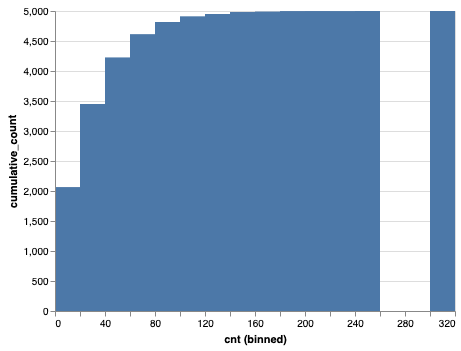

In [240]:
alt.Chart(pd.DataFrame(pd.DataFrame(np.abs(f3t.y-f3t.pred_y))).iloc[:4999,:])\
.transform_window(
    sort=[{'field': 'cnt'}],
    frame=[None, 0],
    cumulative_count='count(*)',
)\
.mark_rect().encode(
    x = alt.X("cnt", bin = alt.Bin(maxbins = 20)),
    y = "cumulative_count:Q"
)

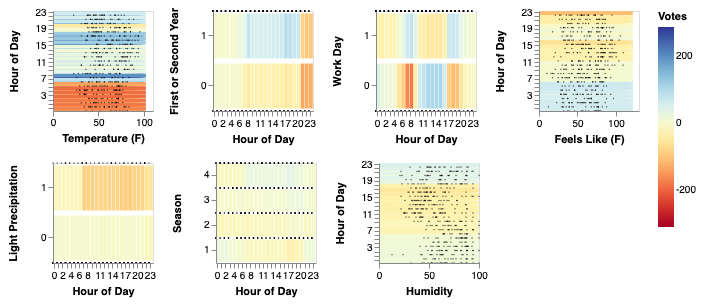

In [462]:
f3t.visualize_components(True, 100)